In [2]:
import os
import glob
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.io as io
import scipy
from scipy.ndimage.filters import gaussian_filter
from matplotlib import cm as CM
import h5py
import json
from PIL import Image,ImageFilter,ImageDraw
import h5py
from sklearn.cross_validation import train_test_split
from PIL import Image,ImageFilter,ImageDraw

/home/jiangdong/.local/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## 1. 生成密度图h5文件（标记）

In [2]:
#this is borrowed from https://github.com/davideverona/deep-crowd-counting_crowdnet
def gaussian_filter_density(gt):
    print(gt.shape)
    density = np.zeros(gt.shape, dtype=np.float32)
    gt_count = np.count_nonzero(gt)
    # 这里对点特别少的图片做处理，忽略（不处理会报错）
    if gt_count <= 5:
        return gt
    pts = np.array(list(zip(np.nonzero(gt)[1], np.nonzero(gt)[0])))
    leafsize = 2048
    # build kdtree
    tree = scipy.spatial.KDTree(pts.copy(), leafsize=leafsize)
    # query kdtree
    distances, locations = tree.query(pts, k=4)

    print('generate density...')
    for i, pt in enumerate(pts):
        pt2d = np.zeros(gt.shape, dtype=np.float32)
        pt2d[pt[1],pt[0]] = 1.
        if gt_count > 1:
            sigma = (distances[i][1]+distances[i][2]+distances[i][3])*0.1
        else:
            sigma = np.average(np.array(gt.shape))/2./2. #case: 1 point
        density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')
    print('done.')
    return density

In [3]:
# 读入数据
root = "/share/dong/Data/baidu_star_2018/image/"
annotation_path = '/share/dong/Data/baidu_star_2018/annotation/annotation_train_stage1.json'
with open(annotation_path) as config_buffer:
    config = json.loads(config_buffer.read())
data = config['annotations']

In [ ]:
# 生成h5文件并储存
for item in data:
    mat = item['annotation']
    img_path = os.path.join(root,item['name'])
    img = plt.imread(img_path)
    k = np.zeros((img.shape[0],img.shape[1]))
    gt = pd.DataFrame(mat).loc[:,'x':'y'].values
    for i in range(0,len(gt)):
        if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:
            k[int(gt[i][1]),int(gt[i][0])]=1
    k = gaussian_filter_density(k)
    with h5py.File(img_path.replace('.jpg','.h5').replace('.png','.h5').replace('train','truth'), 'w') as hf:
            hf['density'] = k

## Ex. 这里是两个脚本，方便直观感受数据

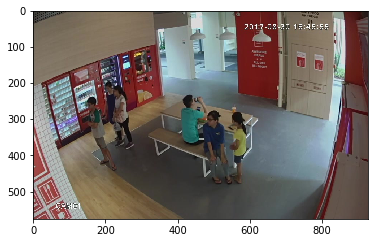

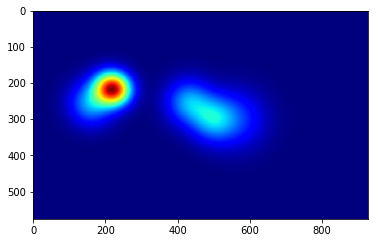

In [22]:
# 这是一个查看脚本 查看某张图片的原图和密度图（修改data下标即可）
item = data[100]
img_path = os.path.join(root,item['name'])
gt_path = img_path.replace('.jpg','.h5').replace('.png','.h5').replace('train','truth')

fig = plt.figure()
img = plt.imread(img_path)
plt.imshow(img)

fig = plt.figure()
try:
    gt_file = h5py.File(gt_path)
    target = np.asarray(gt_file['density'])
except:
    density = np.zeros(img.size, dtype=np.float32)
    target = np.asarray(density)
plt.imshow(target,cmap=CM.jet)

In [8]:
# 这是一个统计脚本，计算生成的h5文件标签与真实标签的差值
# 理论我们的模型能达到的最高精度
acc = 0
mae = 0
for item in config['annotations']:
    root = "/share/liuxiang/baidu_star_2018/image/"
    path = item['name']
    path = os.path.join(root,path)
    gt_path = path.replace('.jpg','.h5').replace('.png','.h5').replace('train','truth')
    try:
        gt_file = h5py.File(gt_path)
        target = np.asarray(gt_file['density'])
    except:
        density = np.zeros(img.size, dtype=np.float32)
        target = np.asarray(density)
    mae += abs((np.sum(target)-item['num']))
    acc += abs((np.sum(target)-item['num'])/item['num'])
print('acc:',acc/len(config['annotations']))
print('mae:',mae/len(config['annotations']))

acc: 0.043640903509650386
mae: 0.7869577703718457


## 2. 划分测试集和训练集

In [ ]:
root = "/share/dong/Data/baidu_star_2018/image/"
annotation_path = '/share/dong/Data/baidu_star_2018/annotation/annotation_train_stage1.json'
# 将json文件中的样本路径拿出来，划分训练和测试集
with open(annotation_path) as config_buffer:
    config = json.loads(config_buffer.read())
img_paths = []
for path in config['annotations']:
    img_paths.append(path)
img_paths = [os.path.join(root,item['name']) for item in config['annotations']]
# 默认划分比例是 0.75: 0.25
train, test = train_test_split(img_paths)
tans_path = '/home/jiangdong/workspace/csr/CSRNet-paddle/baidu_train.json'
with open(tans_path,'w') as outfile:
    data = json.dump(train, outfile)
tans_path = '/home/jiangdong/workspace/csr/CSRNet-paddle/baidu_test.json'
with open(tans_path,'w') as outfile:
    data = json.dump(test, outfile)

## 3.生成预测json文件

In [3]:
root = "/share/dong/Data/baidu_star_2018_test_stage1/baidu_star_2018/image/"
annotation_path = '/share/dong/Data/baidu_star_2018_test_stage1/baidu_star_2018/annotation/annotation_test_stage1.json'
# 将json文件中的样本路径拿出来，划分训练和测试集
with open(annotation_path) as config_buffer:
    config = json.loads(config_buffer.read())
img_paths = [os.path.join(root,item['name']) for item in config['annotations']]
# 默认划分比例是 0.75: 0.25
tans_path = '/home/jiangdong/workspace/csr/CSRNet-paddle/baidu_infer.json'
with open(tans_path,'w') as outfile:
    data = json.dump(img_paths, outfile)